In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

from jax import random
import jax
import jax.numpy as jnp
import torch

import arviz as az
import matplotlib.pyplot as plt

In [191]:
import skbio 
import numpy as np

In [24]:
fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

In [269]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return jnp.array(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
    print('reference ', str(seq))
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    reads_mapped = []
    print('reads')
    for seq in skbio.io.read(freads_in, format='fasta'):
        print(str(seq))
        reads_mapped.append(seq_mapping(str(seq), alphabet))
    return jnp.array(reads_mapped)

In [26]:

alphabet ='ACGT-'
B = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

ref = fasta2ref(fref_in, alphabet)
reads = fasta2reads(freads_in, alphabet) # what about non-unique reads ? 

L=ref.shape[0] # length of genome
N=reads.shape[0] # number of reads

### Simplyfied model with fixed hyperparameters

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)
alphabet = {A, C, G, T, -}

Fixed parameters: 
* mutation rate: $1- \gamma$
* error rate: $1-\theta$
* Dirichlet prior: $\alpha = (\alpha_1, ..., \alpha_k)$

Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$  
Cluster assignments ($N$-dim): $z|\pi \sim Categorical(\pi)$  
Cluster centers/haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=
\begin{cases} 
\gamma,  \text{ if }i = ref[l] \\
\frac{1-\gamma}{4}, \text{ else. }
\end{cases}$ for $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  
Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=
\begin{cases} 
\theta,  \text{ if }i = h_{z_n}[l] \\
\frac{1-\theta}{4}, \text{ else. }
\end{cases}$ for $n \in {1, ..., N}$, $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  



In [27]:
K = 10  # Fixed number of components

# fixed constants
gamma = 0.70
theta = 0.99    


L=ref.shape[0] # length of genome
N=reads.shape[0] # number of reads
B = len(alphabet)

# --- Mutation matrix ----
# LxB-dimensional
weight = np.full((L,B),(1-gamma)/(B-1))
np.put_along_axis(weight, ref.reshape(L,1), gamma, axis=1) # is written into weight
# KxLxB dimensional 
ref_gamma_weight = np.array(K*[weight]) # KxLxB 

# --- Error matrix --- 
# NxLxB dimensional 
weight_theta = np.full((N,L,B),(1-theta)/(B-1))


#@config_enumerate
def model(reads): # reads is N x L dimensional 
    
    # hyperparameter
    alpha = np.ones(K)/K
    
    pi = numpyro.sample('pi', dist.Dirichlet(alpha))
    
    genome_axis = numpyro.plate('genome_axis', L, dim=-1)
    with numpyro.plate('haplo_axis', K, dim=-2):
        with genome_axis:
            h = numpyro.sample('h', dist.Categorical(ref_gamma_weight))
            print('h ', h.shape)
    
    with numpyro.plate('read_axis', N,dim=-2):
        z = numpyro.sample('z', dist.Categorical(pi))
        print('z ', h.shape)

        with genome_axis:
            weight_theta = np.full((N,L,B),(1-theta)/(B-1))
            np.put_along_axis(weight_theta, h[z].reshape(N,L,1), theta, axis=2)
            print('weight_theta ', weight_theta.shape)
            numpyro.sample('obs', dist.Categorical(weight_theta), obs=reads) # N x L dimensional 
            
    #print(f"     pi.shape = {pi.shape}")
    #print(f"     h.shape = {h.shape}")
    #print(f"     z.shape = {z.shape}")
    

In [28]:
print('genome lengt = L =', L)
print('number of reads = N =', N) # number of reads
print('lenght of alphabet = B =', B)

genome lengt = L = 7
number of reads = N = 7
lenght of alphabet = B = 5


In [29]:
rng_key = jax.random.PRNGKey(0)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, reads)

h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)
h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)
h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)


  0%|                                                                                                                                                   | 0/3000 [00:00<?, ?it/s]


h  (10, 7)
z  (10, 7)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[7,7,1])>with<DynamicJaxprTrace(level=2/1)>
While tracing the function while_body_fun at /Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/jax/_src/lax/control_flow.py:139 for while_loop, this concrete value was not available in Python because it depends on the value of the argument 'loop_carry'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

## Minimal case: Reduction to 1 position sequence

In [145]:
"""
Defining put_along_axis() from numpy for jax.numpy. 
Essentially copied the code from 
https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/lib/shape_base.py#L29

"""

import numpy.core.numeric as _nx

def _make_along_axis_idx(arr_shape, indices, axis):
    # compute dimensions to iterate over
    if not _nx.issubdtype(indices.dtype, _nx.integer):
        raise IndexError('`indices` must be an integer array')
    if len(arr_shape) != indices.ndim:
        raise ValueError(
            "`indices` and `arr` must have the same number of dimensions")
    shape_ones = (1,) * indices.ndim
    dest_dims = list(range(axis)) + [None] + list(range(axis+1, indices.ndim))

    # build a fancy index, consisting of orthogonal aranges, with the
    # requested index inserted at the right location
    fancy_index = []
    for dim, n in zip(dest_dims, arr_shape):
        if dim is None:
            fancy_index.append(indices)
        else:
            ind_shape = shape_ones[:dim] + (-1,) + shape_ones[dim+1:]
            fancy_index.append(_nx.arange(n).reshape(ind_shape))

    return tuple(fancy_index)

def custom_put_along_axis(arr, indices, values, axis):
    """
    Parameters
    ----------
    arr : ndarray (Ni..., M, Nk...)
        Destination array.
    indices : ndarray (Ni..., J, Nk...)
        Indices to change along each 1d slice of `arr`. This must match the
        dimension of arr, but dimensions in Ni and Nj may be 1 to broadcast
        against `arr`.
    values : array_like (Ni..., J, Nk...)
        values to insert at those indices. Its shape and dimension are
        broadcast to match that of `indices`.
    axis : int
        The axis to take 1d slices along. If axis is None, the destination
        array is treated as if a flattened 1d view had been created of it.
    
    """
    
    # normalize inputs
    if axis is None:
        arr = arr.flat
        axis = 0
        arr_shape = (len(arr),)  # flatiter has no .shape
    else:
        #axis = normalize_axis_index(axis, arr.ndim)
        arr_shape = arr.shape

    # use the fancy index
    arr = arr.at[tuple(_make_along_axis_idx(arr_shape, indices, axis))].set(values)
    return arr

In [270]:
# --- 1. Example ----

reference = jnp.array([0])
reads = jnp.array([[0], [1], [1], [1], [0], [1], [0], [1]])

input_data = reference, reads

# --- 2. Example ----
fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

alphabet ='ACGT-'
B = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

reference = fasta2ref(fref_in, alphabet)
print('reference ')
print(reference)
reads = fasta2reads(freads_in, alphabet)
print('reads ')
print(reads)

input_data = reference, reads

cluster_num = 10

reference  GTTGAGT
reference 
[2 3 3 2 0 2 3]
reads
GTAAAGT
GTTGAGT
GTTGAGT
GTTGAGT
GTTTAGT
GTTTAGT
GTTTAGT
reads 
[[2 3 0 0 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]]


In [252]:
def model_1dim(input_data):
    reference, read_data = input_data

    # parameters
    read_count = read_data.shape[0]
    genome_length = read_data.shape[1]
    alphabet_length = 5

    # define rates
    mutation_rate = numpyro.sample('mutation_rate', dist.Beta(1, 1))
    error_rate = numpyro.sample('error_rate', dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full((genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1))
    mutation_rate_matrix = custom_put_along_axis(mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1)
    #mutation_rate_matrix = jnp.array([mutation_rate, 1 - mutation_rate])

    alpha = jnp.ones(cluster_num) / cluster_num
    cluster_weights = numpyro.sample("cluster_weights", dist.Dirichlet(alpha))

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", cluster_num, dim=-2):
        with genome_axis:
            haplotypes = numpyro.sample("haplotypes", dist.Categorical(mutation_rate_matrix))  # cluster centers

    with numpyro.plate("read_axis", read_count, dim=-2):
        cluster_assignments = numpyro.sample("cluster_assignments", dist.Categorical(cluster_weights))
        with genome_axis:
            error_rate_matrix = jnp.full((read_count, genome_length, alphabet_length), (1 - error_rate) / (alphabet_length - 1))
            error_rate_matrix = custom_put_along_axis(error_rate_matrix, haplotypes[cluster_assignments].reshape(read_count, genome_length, 1), error_rate, axis=2)
            #error_rate_matrix = jnp.array([error_rate, 1 - error_rate])
            obs=numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

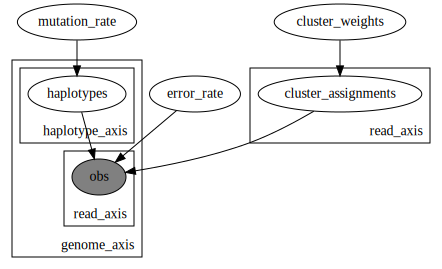

In [253]:
numpyro.render_model(model_1dim, model_args=(input_data,))

In [254]:
rng_key = jax.random.PRNGKey(0)

num_warmup, num_samples = 2000, 10000

# Run NUTS. How many chains? 
kernel = NUTS(model_1dim)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, input_data)

sample: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:40<00:00, 294.65it/s, 31 steps of size 7.51e-02. acc. prob=0.92]


In [256]:
mcmc.print_summary()
# r_hat is the Gelman Rubin 


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_assignments[0,0]      4.48      2.86      4.00      1.00      9.00    444.37      1.00
cluster_assignments[1,0]      4.68      2.91      5.00      1.00      9.00    567.91      1.00
cluster_assignments[2,0]      4.68      2.91      5.00      1.00      9.00    578.97      1.00
cluster_assignments[3,0]      4.67      2.91      5.00      1.00      9.00    566.66      1.00
cluster_assignments[4,0]      4.46      2.90      4.00      1.00      9.00     38.34      1.04
cluster_assignments[5,0]      4.43      2.90      4.00      1.00      9.00     38.97      1.04
cluster_assignments[6,0]      4.46      2.90      4.00      1.00      9.00     39.16      1.04
      cluster_weights[0]      0.08      0.16      0.00      0.00      0.32    136.16      1.01
      cluster_weights[1]      0.11      0.19      0.00      0.00      0.43     56.34      1.00
      cluster_weights[2]      0.12      0.19     

In [272]:
posterior_samples = mcmc.get_samples()

In [273]:
# Make sure to infer_discrete
# Predictive obtained by running model conditioned on latent samples from posterior_samples p(theta | data)

posterior_predictive = Predictive(model_1dim, posterior_samples, infer_discrete=True, return_sites=["cluster_assignments"])
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)

In [243]:
jnp.unique(posterior_predictions['cluster_assignments'][:,6], return_counts=True)

(DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 DeviceArray([3004, 1405, 1731,   10,  758,  313,   15,  555, 1128, 1081], dtype=int32))

In [201]:
# Add "cluster_assignments" values to mcmc samples

posterior_samples["cluster_assignments"] = posterior_predictions["cluster_assignments"]

In [187]:
#jnp.unique(posterior_samples["cluster_assignments"][:,0,0], return_counts=True)

In [274]:
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictions,
)
display(inference_data)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [282]:
# make predictions, we also get negative predictions

posterior_predictive = Predictive(model_1dim, posterior_samples, infer_discrete=True, return_sites=["haplotypes"])
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)
pred1 = posterior_predictions['haplotypes']
print(pred1.shape)
print(pred1.mean(axis=0))
pred1= pred1.mean(axis=0)

(10000, 10, 7)
[[1.9999     2.8759     2.7254     1.961      0.24049999 2.006
  2.8767    ]
 [2.0074     2.8948     2.7508     2.0444     0.22479999 1.9943999
  2.8866    ]
 [2.0016     2.8897998  2.7154     2.0214     0.2189     2.0029
  2.8934    ]
 [2.0007     2.8825     2.7393     1.9715999  0.2411     1.9957
  2.8755    ]
 [1.9963     2.8837     2.7451     2.0489     0.21329999 2.0036
  2.8889    ]
 [2.0052     2.8858     2.7092     1.9497999  0.2619     2.0024
  2.8686    ]
 [1.9998     2.8895     2.7538     1.9829999  0.2516     1.9986
  2.8795    ]
 [2.0063     2.8848     2.7335     1.9837999  0.25239998 2.0004
  2.8724    ]
 [1.9977     2.8834999  2.7561998  2.0284     0.2215     2.0022
  2.8797    ]
 [2.0047998  2.8894     2.7617     2.0321     0.2338     2.0016
  2.8876998 ]]


In [281]:
# make predictions, we also get negative predictions

posterior_predictive = Predictive(model_1dim, posterior_samples, infer_discrete=True, return_sites=["cluster_assignments"])
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)
pred1 = posterior_predictions['cluster_assignments']
print(pred1.shape)
print(pred1.mean(axis=0))
pred1= pred1.mean(axis=0)

(10000, 7, 1)
[[4.4797997]
 [4.6809998]
 [4.6775   ]
 [4.6716   ]
 [4.4557   ]
 [4.4347   ]
 [4.4603   ]]


[[2. 3. 0. 0. 0. 2. 3.]
 [2. 3. 3. 2. 0. 2. 3.]
 [2. 3. 3. 2. 0. 2. 3.]
 [2. 3. 3. 2. 0. 2. 3.]
 [2. 3. 3. 3. 0. 2. 3.]
 [2. 3. 3. 3. 0. 2. 3.]
 [2. 3. 3. 3. 0. 2. 3.]]


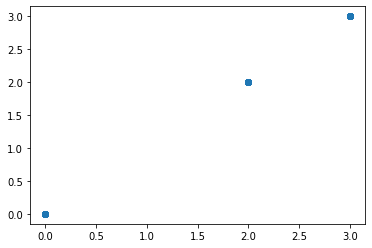

In [275]:
# make predictions, we also get negative predictions

posterior_predictive = Predictive(model_1dim, posterior_samples, infer_discrete=True)
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)
pred1 = posterior_predictions['obs']
print(pred1.mean(axis=0))
pred1= pred1.mean(axis=0)
plt.scatter(input_data[1], pred1)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

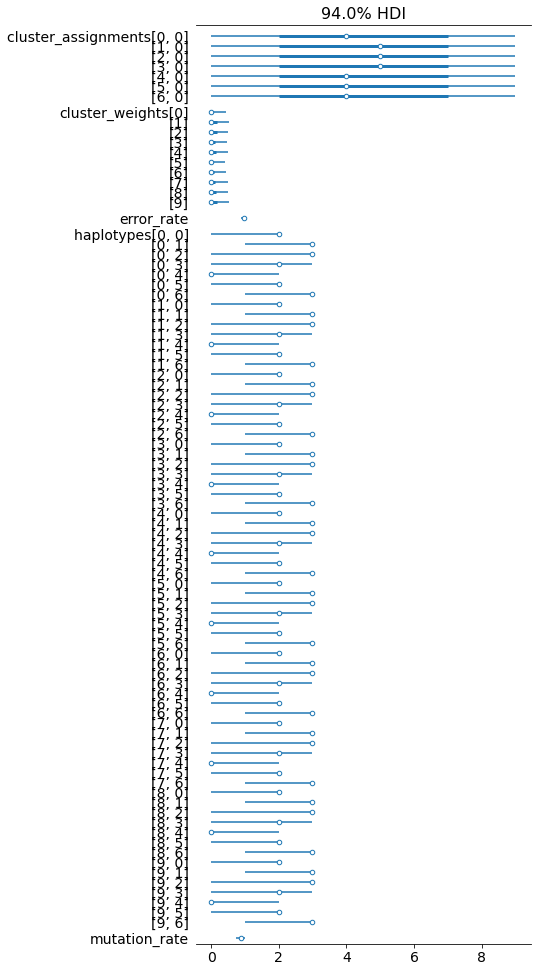

In [276]:
az.plot_forest(inference_data, combined=True)

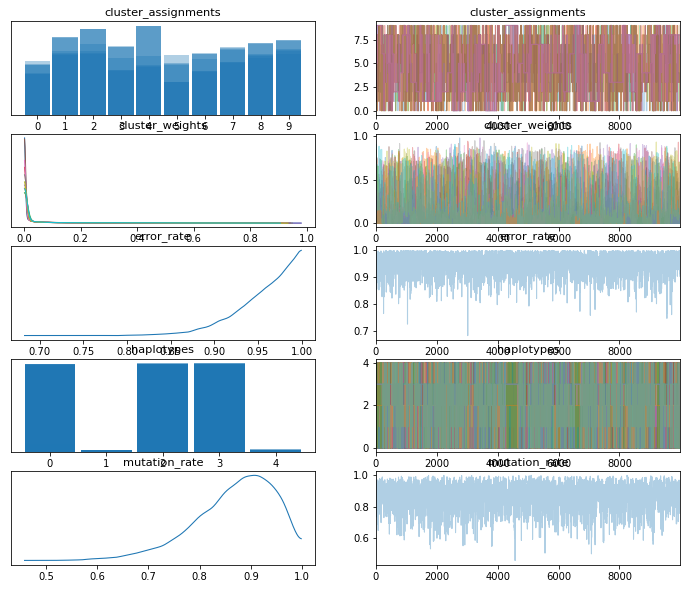

In [277]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)
plt.show()

In [264]:
def convert_h_to_seq(h, alphabet):
    '''
    Print the reconstructed haplotypes
    '''
    for k in range(h.shape[0]):
        seq=[]
        for base in h[k]:
            seq.append(alphabet[base])
        print(k,':',''.join(seq))

In [265]:
# Thats the sampled haplotypes

convert_h_to_seq(posterior_samples['haplotypes'][-1:][0], alphabet)

0 : GTAGAGT
1 : GTCGTGT
2 : GTTGAGT
3 : GTAAAGT
4 : G-TGAGT
5 : GTTGAGT
6 : GTTGAGC
7 : CTTGAGT
8 : GTTTAGT
9 : GTTGAGT


In [271]:
# here are the sampled cluster assignments 

posterior_samples['cluster_assignments'][-1:][0]

DeviceArray([[3],
             [9],
             [9],
             [9],
             [8],
             [8],
             [8]], dtype=int32)

Thats the input reads  
GTAAAGT  
GTTGAGT  
GTTGAGT  
GTTGAGT  
GTTTAGT  
GTTTAGT  
GTTTAGT  
